In [8]:
import torch
import torch.nn as nn #oop
import torch.nn.functional as F #functions
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

#from sklearn import datasets
from tqdm import tqdm

import sklearn.metrics as sk_m
from sklearn.metrics import plot_confusion_matrix

from IPython import embed

import os
import pickle
import shutil

%matplotlib notebook

In [9]:
class Net(torch.nn.Module): #inherits from nn.Module
    
    def __init__(self, lr, num_features, num_classes, loss, network, kernel_size, num_filters):
        
        super(Net, self).__init__() #initialize nn.Module
        
        self.alpha = lr
        self.num_features = num_features
        self.num_classes = num_classes
        self.loss_choice = loss
        self.network = network
        self.kernel_size = kernel_size
        self.num_filters = num_filters
            
        # MLP
        if(self.network.lower() == "mlp"):
            self.network = torch.nn.Sequential(torch.nn.Linear(num_features, 512),
                                               torch.nn.ReLU(),
                                               torch.nn.Linear(512, 256),
                                               torch.nn.ReLU(),
                                               torch.nn.Linear(256, 128),
                                               torch.nn.ReLU(),
                                               torch.nn.Linear(128, 64),
                                               torch.nn.ReLU(),
                                               torch.nn.Linear(64, num_classes))
#             self.network = torch.nn.Sequential(torch.nn.Linear(num_features, 64),
#                                                torch.nn.ReLU(),
#                                                torch.nn.Linear(64, 64),
#                                                torch.nn.ReLU(),
#                                                torch.nn.Linear(32, 32),
#                                                torch.nn.ReLU(),
#                                                torch.nn.Linear(32, 16),
#                                                torch.nn.ReLU(),
#                                                torch.nn.Linear(16, num_classes))
        # CNN
        if(self.network.lower() == "cnn"):
            # experiment 2 has kernel size 5
            self.extract = torch.nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = kernel_size, stride = 1, padding = 1),
                                               nn.ReLU(inplace=True),
                                               nn.MaxPool2d(2),
                                               nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size = kernel_size, stride = 1, padding = 1),
                                               nn.ReLU(inplace=True),
                                               nn.MaxPool2d(2),
                                               nn.Conv2d(in_channels = 4, out_channels = 4, kernel_size = kernel_size, stride = 1, padding = 1),
                                               nn.ReLU(inplace=True),
                                               nn.MaxPool2d(2)
                                                )
            # in_channels = 1 for grayscale
            # out_channels -> number of shared weights / features
            # kernel size -> nxn kernel size
            # stride -> how many pixels we move at a time
            # padding -> adds 1 pixesl of zeros to each side of each dimension to maintain spatial dimensions for our kernel size
            self.decimate = torch.nn.Sequential(nn.Linear(4 * (7*7), 12),
                                                nn.ReLU(inplace=True),
                                                nn.Linear(12, num_classes)
                                                )
        
        # RBFN
        
    def init_optimizer(self):
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr = self.alpha)
        
        #self.optimizer = torch.optim.SGD(self.parameters(), lr = self.alpha)

    def objective(self, preds, labels): # this is the loss function
        
        #preds = F.log_softmax(preds, dim = 1) # dim 1: distribute across output layer of tensors. like np's axis param
    
        loss = torch.nn.MSELoss()
        
        return loss(preds, labels)
    
    def forward(self, x): # you can complicate the network in the forward() method.
        
        if(self.network.lower() == "mlp"):
            x = self.network(x)
        
            return x
        
        if(self.network.lower() == 'cnn'):
            features = self.extract(x)
            features = features.view(features.size()[0], -1)
            output = self.decimate(features)
            
            return output
    

In [10]:
which_dataset = "mnist" # "mnist" or "fashion"
which_network = "cnn"

loss_choice = "mse"

batch_size = 16
num_features = 784
num_classes = 10

alpha = 1e-4 

kernel_size = 3
num_filters = 8

OrderedDict([('extract.0.weight', tensor([[[[ 0.0530, -0.3170, -0.1157],
          [-0.2249, -0.2430, -0.0603],
          [-0.0006,  0.1157, -0.2625]]],


        [[[ 0.1138,  0.3140,  0.0194],
          [-0.2122, -0.3121,  0.1476],
          [ 0.3307, -0.1072, -0.1661]]]])), ('extract.0.bias', tensor([-0.0880,  0.1038])), ('extract.3.weight', tensor([[[[ 8.2184e-02,  1.6914e-01, -1.5808e-01],
          [ 7.2971e-02,  4.5008e-02, -1.9236e-01],
          [ 1.9568e-01, -1.5880e-02, -2.2294e-01]],

         [[-2.1041e-01,  2.0466e-01,  7.5220e-02],
          [-2.3338e-01,  6.7327e-02,  1.6454e-01],
          [-6.5474e-02,  9.4923e-02,  1.9248e-01]]],


        [[[-1.9763e-02,  4.2477e-02, -2.3442e-01],
          [ 1.7633e-01, -2.3019e-01,  9.6147e-02],
          [ 2.1891e-04,  1.5818e-01,  1.5337e-01]],

         [[-2.2087e-01, -1.7214e-01,  7.1981e-02],
          [ 1.7046e-01,  3.2487e-02,  3.9142e-02],
          [-8.2104e-02,  2.2991e-01, -6.8659e-03]]],


        [[[ 4.0985e-02,  2.266

<IPython.core.display.Javascript object>


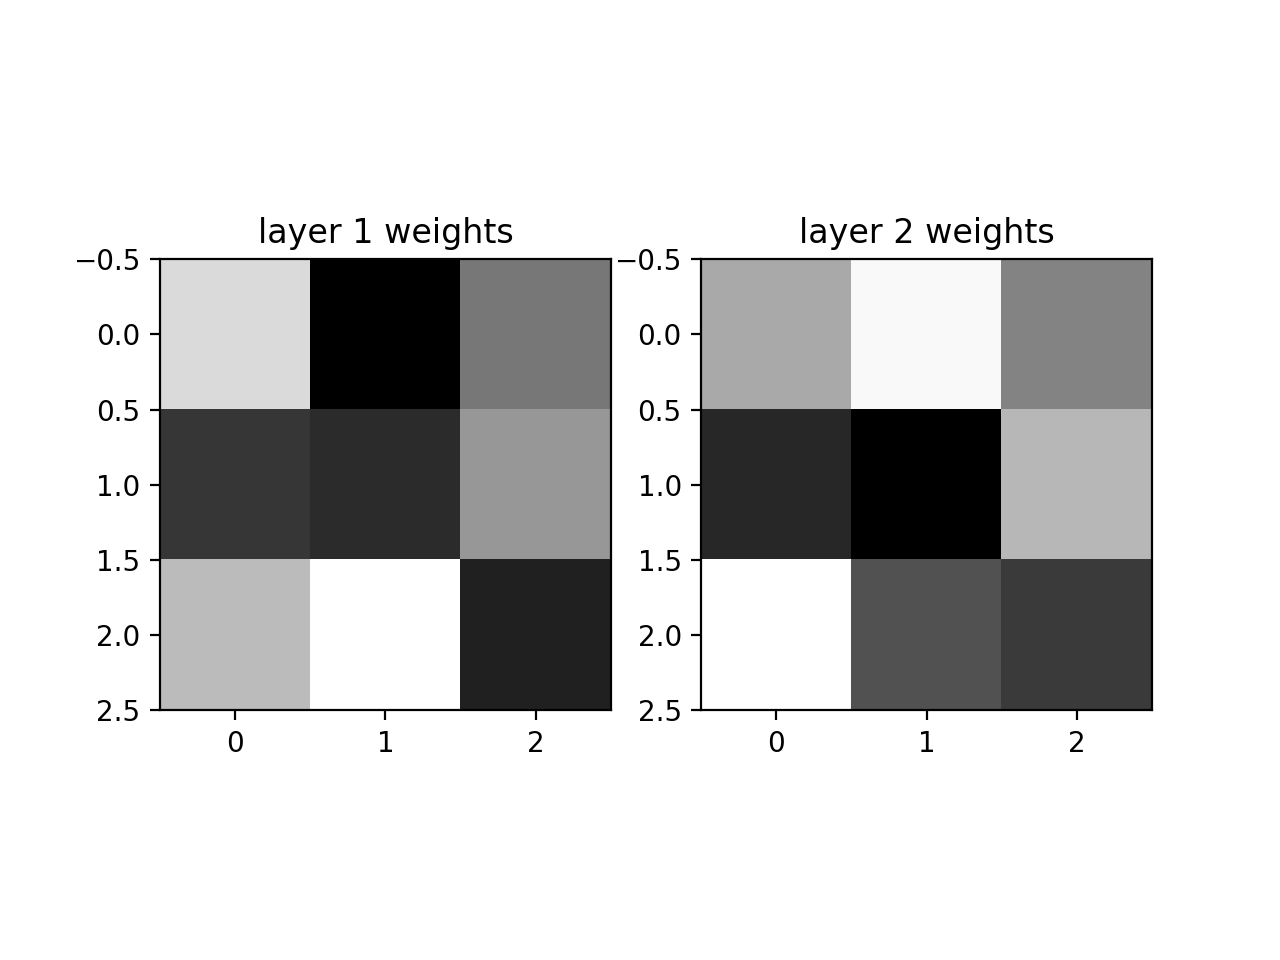

<bound method Figure.tight_layout of <Figure size 640x480 with 2 Axes>>

In [11]:
model = Net(alpha, num_features, num_classes, loss_choice, which_network, kernel_size, num_filters)

torch.save(model.state_dict(), "2_layers_3_kernels.pt")

new_model = Net(alpha, num_features, num_classes, loss_choice, which_network, kernel_size, num_filters)
new_model.load_state_dict(torch.load("test.pt"))
new_model.eval()

print(new_model.state_dict())

conv_weights = new_model.extract[0].weight.data.numpy()
conv_weights[0].shape

fig, ax = plt.subplots(1, 2)

ax[0].imshow(conv_weights[0,0], cmap = 'gray')
ax[0].set_title("layer 1 weights")
ax[1].imshow(conv_weights[1,0], cmap = 'gray')
ax[1].set_title("layer 2 weights")

fig.tight_layout